## Import

### Chargement

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, 
                             roc_curve, precision_recall_fscore_support, brier_score_loss)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.decomposition import PCA

from imblearn.metrics import classification_report_imbalanced 


import pickle
from joblib import load
import cloudpickle

df=pd.read_csv("data/data_2024-25.csv") 

df.head(1)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2024-05-1,Adelaide,7.9,19.2,0.0,4.2,6.6,SE,35.0,ESE,...,74.0,42.0,1033.5,1029.2,7.0,NaN,12.4,18.5,No,No


In [3]:
#Conserver les noms des colonnes, et des stations présents initialement
nom_colonne_initial = df.columns
nom_station_initial = list(set(df["Location"]))

### Suppression des stations avec > 25% de NAN

C:\Users\Amélie\AppData\Local\Temp\ipykernel_7308\2300697080.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  manque_location_apres = df.groupby("Location").apply(lambda x: x.isnull().mean() * 100).mean(axis=1).sort_values(ascending=False)


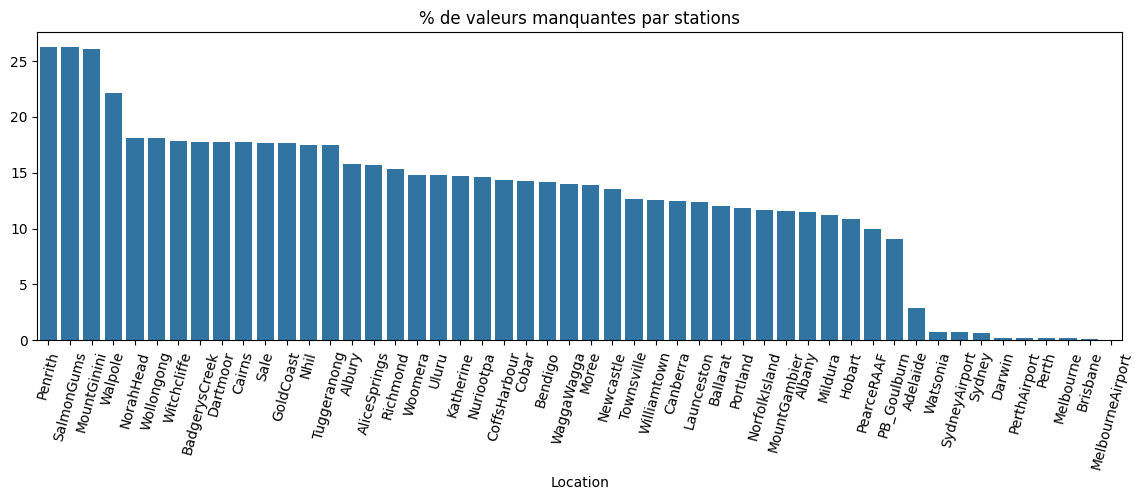

In [4]:
manque_location_apres = df.groupby("Location").apply(lambda x: x.isnull().mean() * 100).mean(axis=1).sort_values(ascending=False)

plt.figure(figsize=(14, 4))
sns.barplot(x=manque_location_apres.index, y=manque_location_apres.values)
plt.xticks(rotation=75)
plt.title('% de valeurs manquantes par stations')
plt.show()

In [5]:
# 1. Suppression des stations avec >25% de manquant 
### En entrainement : Supprimait Penrith, SalmonsGums, MountGini, Newcastle // Suppression manuelle en plus de ['Williamtown', 'Melbourne'] chez ABO

# Nombre total de cellules par Location
total_cells_per_location = df.groupby("Location").size() * (df.shape[1] - 1)  # -1 pour exclure la colonne Location elle-même
# Nombre total de NaN par Location (toutes colonnes sauf 'Location')
nan_counts_per_location = df.drop(columns="Location").isna().groupby(df["Location"]).sum().sum(axis=1)
# Ratio NaN global par Location
nan_ratio = nan_counts_per_location / total_cells_per_location
# Locations valides (moins de 25% de NaN global)
valid_locations = nan_ratio[nan_ratio <= 0.25].index
# Filtrage du DataFrame
df = df[df["Location"].isin(valid_locations)]

### Ajout de features

In [6]:
# Latitude, Longitude
df_dico_station_geo = pd.read_csv("dico_scaler\localisations_gps.csv", index_col="Location")

df = df.merge(right=df_dico_station_geo, left_on="Location", right_index=True, how="left")

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Amélie\AppData\Local\Temp\ipykernel_7308\2477794889.py:2: SyntaxWarning: invalid escape sequence '\l'
  df_dico_station_geo = pd.read_csv("dico_scaler\localisations_gps.csv", index_col="Location")


In [7]:
def update_station_geo_csv(csv_path: str,
                           updates: dict[str, tuple[float, float]]) -> None:
    """
    Ajoute ou met à jour des lignes dans un CSV de géolocalisations.

    Le CSV doit avoir au minimum ces colonnes :
      Location,Latitude,Longitude

    Args:
      csv_path: chemin vers le fichier CSV à modifier.
      updates:  dict {Location: (Latitude, Longitude)}.
    """
    # 1. Charger le CSV en DataFrame (indexé par Location)
    df = pd.read_csv(csv_path, index_col="Location")

    # 2. Pour chaque entrée du dict, ajouter ou écraser
    for location, (lat, lon) in updates.items():
        df.loc[location] = (lat, lon)

    # 3. Réécrire le CSV
    df.to_csv(csv_path, index=True)

In [8]:
update_station_geo_csv(
    "dico_scaler/localisations_gps.csv",
    {
      "PB_Goulburn": (-34.810, 149.725),
    }
)

In [9]:
# Date, Saison
df["Date"]=pd.to_datetime(df["Date"], format = "%Y-%m-%d")
df["Month"] = df['Date'].dt.month
df["Year"] = df['Date'].dt.year
df["Saison"] = df["Month"].apply( lambda x : "Eté" if x in [12, 1, 2] else "Automne" if x in [3, 4, 5] else "Hiver" if x in [6, 7, 8] else "Printemps")

In [10]:
# Analyse géographique des précipitations

# Dictionnaire climat
climat_mapping = pd.read_csv("dico_scaler\climat_mapping.csv", index_col="Location")
climat_mapping_series = climat_mapping.squeeze()  # Convertir en Series pour faciliter le mapping

# Ajout de la colonne climate au dataframe
df['Climat'] = df["Location"].map(climat_mapping_series) #pour chaque valeur de df.Location, on récupère la valeur correspondante dans climat_mapping
distrib_climat = df["Climat"].value_counts(normalize=True)*100

print(distrib_climat)


Climat
Tempéré        50.000000
Subtropical    26.086957
Désert          8.695652
Tropical        8.695652
Aride           6.521739
Name: proportion, dtype: float64


<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Amélie\AppData\Local\Temp\ipykernel_7308\3527540102.py:4: SyntaxWarning: invalid escape sequence '\c'
  climat_mapping = pd.read_csv("dico_scaler\climat_mapping.csv", index_col="Location")


### @Florent : Dans le jeu de données nous avons "PB_Goulburn" qui est une station de Australian Capital Territory jamais vue par le modèle, il lui faudrait Latitude, Longitude et Climat. Pour les coordonnées j'ai fait un "dico_station_geo.pkl" à partir de ton "liste_station" de ton EDA puis une fonction pour mettre à jour le dico de coordonnées quand on rencontre de nouvelles stations.
Pour le climat, j'ai juste complété à la main en mettant Tempéré, mais je ne sais pas si c'est bon.

In [11]:
# Ajout manuel de Climat
df.loc[df["Location"] == "PB_Goulburn", "Climat"] = df.loc[df["Location"] == "PB_Goulburn", "Climat"].fillna("Tempéré")


In [12]:
locations_climat_nan = df.groupby("Location")["Climat"].apply(lambda x: x.isna().all())

# Filtrer uniquement celles où c'est toujours NaN
locations_climat_nan = locations_climat_nan[locations_climat_nan].index.tolist()
print(locations_climat_nan)


[]


### Suppression

In [13]:
# 2. Suppression des features 
df = df.drop(["Sunshine","Evaporation"], axis = 1)


In [14]:
# 3. Traitement de la variable cible : Suppression des NaN et Label Encoder
df = df.dropna(subset=["RainTomorrow"], axis=0, how="any")

encoder=LabelEncoder()
df["RainTomorrow"] = encoder.fit_transform(df["RainTomorrow"])  #N=0, Y=1

## Qq remarques : à supprimer ensuite

Warning pour Florent : 

=> RAF EDA : Faire plus tot suppression de 25%, ajout jour +dico station pour mes visuels , puis les supprimer à la fin de l'EDA. Attention la modif de % va modifier le nb de lignes du fichier de sortie actuelle de Florent. Je te laisse relancer ta pipeline après mes modifs? (Je peux les faire Lundi dans le NB google colab EDA4 - ABO)


=> A mettre après son EDA : (par rapport à ce qui est fait actuellement) suppression enregistrement <2009, suppression NaN de Rain Today
=> Conserver Raintoday : Cette feature a été ajoutée après la construction du dataset (non présent dans les données exportées du BOM) et apporte colinéarité (car calculer sur Rainfall)
=> L'enelever devrait alléger ton temps de traitement des NAN

## Scope Florent 

In [15]:
#Pour info - Récap des suppressions
nom_colonne_actuel = df.columns
print("Colonnes ajoutées :",[col for col in nom_colonne_actuel if col not in nom_colonne_initial])
print("Colonnes enlevées :",[col for col in nom_colonne_initial if col not in nom_colonne_actuel])


nom_station_actuel = list(set(df["Location"]))
print("Stations enlevées :",[station for station in nom_station_initial if station not in nom_station_actuel])

Colonnes ajoutées : ['Latitude', 'Longitude', 'Month', 'Year', 'Saison', 'Climat']
Colonnes enlevées : ['Evaporation', 'Sunshine']
Stations enlevées : ['SalmonGums', 'Penrith', 'MountGinini']


In [16]:
df_florent = df.dropna(subset=["RainToday"], axis=0, how="any")
df_florent.head(1)
# Export en csv -> Même scope que fin de fichier EDA

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Temp9am,Temp3pm,RainToday,RainTomorrow,Latitude,Longitude,Month,Year,Saison,Climat
0,2024-05-01,Adelaide,7.9,19.2,0.0,SE,35.0,ESE,SE,15.0,...,12.4,18.5,No,0,-34.928181,138.599931,5,2024,Automne,Tempéré


# Scope ABO

## Preprocessing

In [17]:
# Suppressions des features inutiles 
df = df.drop(["RainToday","Saison","Climat"], axis = 1)

### Complétions autorisées des NAN

In [18]:
# Créations de colonnes temporaire pour aider à la complétion
df["WarmerTemp"] = df[["Temp9am", "Temp3pm"]].max(axis=1)
#Traiter les NAN de MaxTemp, Temp3pm, Pressure9am, Pressure3pm où corrélation >0.96
df["MaxTemp"]=df["MaxTemp"].fillna(df["WarmerTemp"].round(0)) #arrondi à l'entier comme la definition du BOM
df = df.drop(["WarmerTemp"],axis=1)

df["Temp3pm"]=df["Temp3pm"].fillna(df["MaxTemp"]) #Si on prenait WarmerTemp, il serait composé uniquement de Temp9am en l'absence de Temp3pm. Or le taux de corrélation de Temp9am est moins intéressant que MaxTemp

#0.964# montrer nb de NaN avant et après
df["Pressure3pm"]=df["Pressure3pm"].fillna(df["Pressure9am"])
df["Pressure9am"]=df["Pressure9am"].fillna(df["Pressure3pm"])

### Encodage Statless 

#### Fonctions Encodage Statless 

In [19]:
#Encodage cyclique du mois 
def encode_month(df, month_col="Month"):
    """Encode le mois en sin et cos puis supprime la colonne originale."""
    df['month_sin'] = np.sin(2 * np.pi * (df[month_col] - 1) / 12)
    df['month_cos'] = np.cos(2 * np.pi * (df[month_col] - 1) / 12)
    df=df.drop(columns=[month_col],axis=1)
    return df

In [20]:
def encode_wind_direction(df):
    # Encodage cyclique de la direction du vent (et du cas "pas de vent")
    # 1) Définir la liste des 16 directions cycliques (rose des vents)
    # ------------------------------------------------------------------------
    #    Ici, on ordonne explicitement les directions dans le sens horaire,
    #    en commençant par "N" à l’indice 0, puis "NNE", "NE", etc.
    directions = [
        "N",   "NNE", "NE",  "ENE",
        "E",   "ESE", "SE",  "SSE",
        "S",   "SSW", "SW",  "WSW",
        "W",   "WNW", "NW",  "NNW"
    ]

    # ------------------------------------------------------------------------
    # 2) Construire le mapping direction → angle (en radians)
    # ------------------------------------------------------------------------
    #    Chaque direction est associée à un angle = idx * (2π / 16),
    #    où idx est l’indice de la direction dans la liste ci-dessus.
    #    Ex. : "N" → 0 rad, "ENE" → 3 * (2π/16) = 3π/8, etc.
    angle_mapping = {
        dir_name: (idx * 2 * np.pi / 16)
        for idx, dir_name in enumerate(directions)
    }

    # ------------------------------------------------------------------------
    # 3) Parcourir chaque couple (colonne de direction, colonne de vitesse)
    #    - Pour WindDir9am et WindDir3pm, on gère le cas “pas de vent”.
    #    - Pour WindGustDir, la vitesse est toujours > 0 (pas de “pas de vent”).
    #    On crée pour chaque couple :
    #      • des colonnes sin/cos de l’angle (avec NaN si direction absente),
    #      • éventuellement un indicateur NoWind_<col_speed> pour WindDir9am/3pm.
    # ------------------------------------------------------------------------
    for (col_dir, col_speed) in [
        ("WindDir9am",  "WindSpeed9am"),
        ("WindDir3pm",  "WindSpeed3pm"),
        ("WindGustDir", "WindGustSpeed")
    ]:
        # ------------------------------------------------------------
        # Détection du cas “pas de vent” ET direction absente/blanche
        # ------------------------------------------------------------
        handle_no_wind = col_dir in ["WindDir9am", "WindDir3pm"]
        if handle_no_wind:
            # a) Détecter les lignes où la vitesse vaut exactement 0
            is_exact_zero = (df[col_speed] == 0)
            # b) Détecter si la direction est manquante : NaN ou chaîne vide
            mask_dir_missing = df[col_dir].isna() | (df[col_dir].astype(str).str.strip() == "")
            # c) Combinaison : “pas de vent” ET direction absente
            mask_no_wind = is_exact_zero & mask_dir_missing
            # d) Créer l’indicateur NoWind_<col_speed> (1 si vitesse == 0)
            #    On met 1 si vitesse = 0, même si direction présente ou non.
            df[f"NoWind_{col_speed}"] = is_exact_zero.astype(int)
        else:
            # Pour WindGust, pas de “pas de vent” → on n’utilise pas NoWind
            is_exact_zero = pd.Series(False, index=df.index)
            mask_no_wind = pd.Series(False, index=df.index)

        # ------------------------------------------------------------
        # Mapper la direction textuelle → angle (NaN si direction absente ou non reconnue)
        # ------------------------------------------------------------
        df[f"{col_dir}_angle"] = df[col_dir].map(angle_mapping)

        # ------------------------------------------------------------
        # Si “pas de vent” ET direction absente, forcer angle = 0 rad
        # ------------------------------------------------------------
        if handle_no_wind:
            df.loc[mask_no_wind, f"{col_dir}_angle"] = 0.0

        # ------------------------------------------------------------
        # Calculer sin(angle) et cos(angle)
        #   • Si angle est NaN (direction absente pour d’autres raisons), sin/cos restent NaN.
        #   • Si “pas de vent”, angle forcé à 0 → sin=0, cos=1.
        #   • Sinon, angle valide → sin(angle), cos(angle).
        # ------------------------------------------------------------
        sin_col = f"{col_dir}_sin"
        cos_col = f"{col_dir}_cos"
        df[sin_col] = np.nan
        df[cos_col] = np.nan

        # a) Cas “pas de vent” (force angle=0) → sin=0, cos=1
        if handle_no_wind:
            df.loc[mask_no_wind, sin_col] = 0.0
            df.loc[mask_no_wind, cos_col] = 1.0

        # b) Cas angle valide pour toutes les lignes
        mask_angle_valid = df[f"{col_dir}_angle"].notna()
        df.loc[mask_angle_valid, sin_col] = np.sin(df.loc[mask_angle_valid, f"{col_dir}_angle"])
        df.loc[mask_angle_valid, cos_col] = np.cos(df.loc[mask_angle_valid, f"{col_dir}_angle"])

        # ------------------------------------------------------------
        # Nettoyage final : supprimer les colonnes de direction textuelle et d’angle
        # ------------------------------------------------------------
        df.drop(columns=[col_dir, f"{col_dir}_angle"], inplace=True)

    # ------------------------------------------------------------------------
    # À l’issue de cette boucle :
    # → Pour WindDir9am et WindDir3pm :
    #     • Une colonne NoWind_<col_speed> (1 si vitesse == 0, 0 sinon).
    #     • Deux colonnes <col_dir>_sin et <col_dir>_cos :
    #         - Si “pas de vent” & direction absente → (0, 1).
    #         - Si vent présent & angle valide → (sin(angle), cos(angle)).
    #         - Si vent présent mais angle manquant → (NaN, NaN).
    #
    # → Pour WindGustDir :
    #     • Pas de colonne NoWind (jamais de “pas de vent”).
    #     • Deux colonnes WindGustDir_sin et WindGustDir_cos :
    #         - Si direction valide → (sin(angle), cos(angle)).
    #         - Sinon (colonne direction initiale absente/mal encodée) → (NaN, NaN).
    # ------------------------------------------------------------------------
    return df

#### Applications des fonctions d'encodage Statless 

In [21]:
# Applications des encodages stateless
df = encode_month(df, "Month")
df = encode_wind_direction(df)

In [22]:
#Récap des suppressions (avant complétion des NaN et normalisation)
nom_colonne_actuel = df.columns
print("Colonnes ajoutées :",[col for col in nom_colonne_actuel if col not in nom_colonne_initial])
print("Colonnes enlevées :",[col for col in nom_colonne_initial if col not in nom_colonne_actuel])


nom_station_actuel = list(set(df["Location"]))
print("Stations enlevées :",[station for station in nom_station_initial if station not in nom_station_actuel])

Colonnes ajoutées : ['Latitude', 'Longitude', 'Year', 'month_sin', 'month_cos', 'NoWind_WindSpeed9am', 'WindDir9am_sin', 'WindDir9am_cos', 'NoWind_WindSpeed3pm', 'WindDir3pm_sin', 'WindDir3pm_cos', 'WindGustDir_sin', 'WindGustDir_cos']
Colonnes enlevées : ['Evaporation', 'Sunshine', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
Stations enlevées : ['SalmonGums', 'Penrith', 'MountGinini']


### Split Features / Variable cible

In [23]:
#Création d'un df de features (X_test) et un de target(y_test)
X_test = df.drop(columns = ["RainTomorrow"])
y_test = df["RainTomorrow"]

### Complétion des NAN

In [24]:
# Chargement du transformer de complétion des NaN pour les nuages
with open("dico_scaler/cloud_imputer.pkl", "rb") as f:
    transformer_cloud = cloudpickle.load(f)

# Application sur le nouveau jeu de données
X_test = transformer_cloud.transform(X_test)

In [25]:
# Chargement du scaler pour la complétion des autres NaN    
with open("dico_scaler/transformer_KNNImputerABO.pkl", "rb") as f:
    transformer = cloudpickle.load(f)

# Application sur le nouveau jeu de données
X_test = transformer.transform(X_test)

### Enrichissement de features et scaling

In [26]:
X_test = X_test.drop(["Date","Location"],axis=1) #Suppression de features ayant aidé à complété les NaN

In [27]:
def amplitude_thermique(X) :
    X["Amplitude_Temp"] = X['MaxTemp']- X['MinTemp']
    X = X.drop(["MaxTemp","MinTemp"],axis=1)        
    return X 

X_test = amplitude_thermique(X_test)

In [28]:
## FONCTIONS pour le scaling

def add_engineered_features(X: pd.DataFrame,
                            ref_year: int = 2007, #ref_year = 1e année du dataset d'entrainement est 0
                            lat0: float = -25.0,
                            lon0: float = 133.0) -> pd.DataFrame:
    X_fe = X.copy()
    # Deltas temporel 
    X_fe['Year_delta']      = X_fe['Year']      - ref_year
    # Deltas géographiques
    # Transformer Latitude et Longitude en Latitude_delta et Longitude_delta : où le centre du dataset d'entrainement est 0, et correspond au centre de l'Australie.    
    # A noter : un degré de longitude à l'équateur = 110km, et à 60°Sud = 60 km . Pour corriger, on peut faire un Haversine et encodage azimut.
    X_fe['Latitude_delta']  = X_fe['Latitude']  - lat0
    X_fe['Longitude_delta'] = X_fe['Longitude'] - lon0
    # Log-transform
    X_fe['Rainfall']    = np.log1p(X_fe['Rainfall'])
    X_fe = X_fe.drop(['Year','Latitude','Longitude'], axis=1)
    return X_fe


# Fonction pour charger et appliquer les scalers sur n’importe quel X
def load_and_apply_scalers(X_fe: pd.DataFrame,
                           import_path: str = "dico_scaler/scalers.joblib"
                          ) -> pd.DataFrame:
    artefact = load(import_path)
    scalers, feats = artefact['scalers'], artefact['feature_lists']
    X_scaled = X_fe.copy()
    for key, cols in feats.items():
        X_scaled[cols] = scalers[key].transform(X_scaled[cols])
    return X_scaled

In [ ]:
# Ajout des features d'ingénierie
X_test_fe = add_engineered_features(X_test, ref_year=2007, lat0=-25.0, lon0=133.0)
# Chargement et application des scalers
X_test  = load_and_apply_scalers(X_test_fe,  import_path="dico_scaler/scalers.joblib")

### Enrichissement des features avancé pour test 2e modele entrainé

In [30]:
# Enrichissement de features : sur la base des features qui n'ont pas été identifiées comme importante par le 1er modèle de Régression Logisitique
def enrichissement_features(X_train):
    X_temp = X_train.copy()

    # 1. Amplitude thermique journalière
    # Usage : mesure la variabilité thermique, un faible delta peut indiquer couverture nuageuse forte.
    # X_temp["Amplitude_Temp"] = X_temp['MaxTemp']-X_temp['MinTemp'] 
    
    # 2. Évolution de la température 9 h → 15 h   #Pas d'amélioration
    # Usage : fort réchauffement diurne peut signaler convection et risque d'orage, qui précède souvent de la pluie.
    # X_temp["delta_temp_9_15"] = X_temp["Temp3pm"] - X_temp["Temp9am"]

    # 3. Température moyenne
    X_temp["Mean_Temp"] = (X_temp["Temp3pm"] - X_temp["Temp9am"])/2

    # 5. Tendance barométrique (9 h → 15 h) #Pas d'amélioration
    # Usage : une chute rapide de pression précède souvent un front pluvieux.
    # X_temp["pressure_trend"] = X_temp["Pressure3pm"] - X_temp["Pressure9am"]

    # 6. Variation d’humidité (9 h → 15 h) #Pas d'amélioration
    # Usage : gain d’humidité diurne peut indiquer évaporation ou advection humide, précurseur de pluie.
    X_temp["humidity_trend"] = X_temp["Humidity3pm"] - X_temp["Humidity9am"]

    # 7. Moyenne de nébulosité #Pas d'amélioration
    # Usage : ciel clair vs couvert, impact direct sur l’activation convective.
    X_temp["cloud_mean"] = (X_temp["Cloud9am"] + X_temp["Cloud3pm"]) / 2

    # 8. Évolution de la couverture nuageuse #Pas d'amélioration
    # Usage : accroissement nuageux de matin à après-midi signale développement de front.
    # X_temp["cloud_delta"] = X_temp["Cloud3pm"] - X_temp["Cloud9am"]

    # 9. Indice de clarté (fraction de ciel découvert)
    # Usage : plus l’indice est élevé, plus le ciel est dégagé.
    X_temp["clearness_index"] = (8 - X_temp["Cloud3pm"]) / 8

    # 10. Gustiness (rafales vs vent soutenu)
    # Usage : un grand écart indique instabilité et cisaillement potentiel.
    X_temp["wind_gustiness"] = X_temp["WindGustSpeed"] - X_temp["WindSpeed3pm"]

    # 11. Composantes vectorielles du vent
    # Usage : permet de capturer la vraie direction/vitesse plutôt que sin/cos seuls.
    X_temp["u_gust"] = X_temp["WindGustSpeed"] * X_temp["WindGustDir_cos"]
    X_temp["v_gust"] = X_temp["WindGustSpeed"] * X_temp["WindGustDir_sin"]
    X_temp["u_9am"] = X_temp["WindSpeed9am"] * X_temp["WindDir9am_cos"]
    X_temp["v_9am"] = X_temp["WindSpeed9am"] * X_temp["WindDir9am_sin"]

    # 12. Angle de saison (mois) en radians
    # Usage : retransforme sin/cos(month) en un angle pour clusteriser saisonnalité.
    X_temp["month_angle"] = np.arctan2(X_temp["month_sin"], X_temp["month_cos"])

    
    X_temp = X_temp.drop(["Temp3pm","Temp9am"],axis=1)
    
    return X_temp


## Modélisation

In [31]:
print("Nb d'échantillons",X_test.shape[0])

Nb d'échantillons 18565


In [32]:
# FONCTION EVALUATION
def evaluation (y_test,y_pred, y_proba, model_name) :
    acc, f1 = accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)

    print(f"\n{model_name} | F1: {f1:.3f} | Acc: {acc:.3f} | Seuil: {best_threshold:.2f}")
    # print("Meilleurs hyperparamètres:", best_params) pourquoi cela ne marche plus?
    print("Classification report:\n", classification_report(y_test, y_pred))
    print("Rapport déséquilibre:\n", classification_report_imbalanced(y_test, y_pred))
    
    ## Création de la figure avec deux sous-graphiques côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Calcul de metrics à afficher sur le graphique
    f1_positive = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_proba)

    ## Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[0], cmap="Blues", values_format="d", colorbar=False)
    axes[0].set_title("Matrice de Confusion")
        
    ## Courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color="darkorange")
    axes[1].plot([0, 1], [0, 1], linestyle='--', color="gray")
    axes[1].set_xlabel("Taux de faux positifs")
    axes[1].set_ylabel("Taux de vrais positifs")
    axes[1].set_title("Courbe ROC")
    axes[1].legend()
    axes[1].grid(True)

    # Titre principal et sous-titre
    fig.suptitle(f"Évaluation du modèle : {model_name}", fontsize=14)
    fig.text(
        0.5,         # x (milieu de la figure)
        0.88,        # y (juste sous le suptitle)
        f"F1-score (classe positive) : {f1_positive:.3f}",
        ha='center', # alignement horizontal centré
        fontsize=12
    )
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Régression Logisitique : Rappel score F1:0.84  | F1+: 0.652 | AUC: 0.879 | Seuil: 0.62


LogReg | F1: 0.416 | Acc: 0.724 | Seuil: 0.63
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82     14591
           1       0.38      0.46      0.42      3974

    accuracy                           0.72     18565
   macro avg       0.61      0.63      0.62     18565
weighted avg       0.74      0.72      0.73     18565

Rapport déséquilibre:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.80      0.46      0.82      0.60      0.38     14591
          1       0.38      0.46      0.80      0.42      0.60      0.35      3974

avg / total       0.74      0.72      0.53      0.73      0.60      0.37     18565



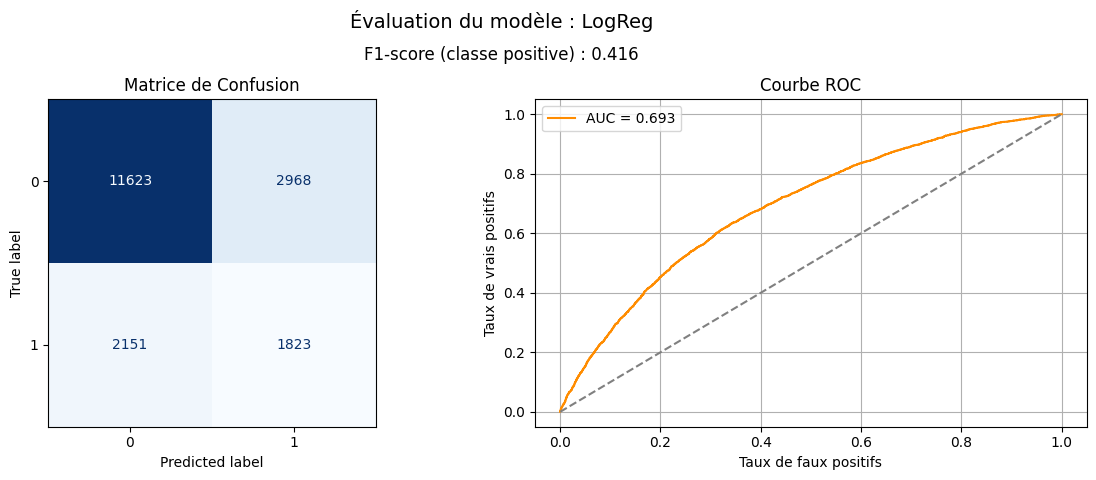

In [33]:
# Charger le classifier et son meilleur seuil
model_name = "LogReg"
nom_type_dataset = "X_train_normal"


data = load("models/{0}_{1}_model_and_threshold.joblib".format(model_name, nom_type_dataset))
best_model     = data["model"]
best_threshold = data["threshold"] # celui du modèle entrainé optimisé

# et pour prédire sur X_new :
y_proba = best_model.predict_proba(X_test)[:,1]
# En reprenant le seuil optimisé
y_pred  = (y_proba >= best_threshold).astype(int)

evaluation (y_test,y_pred, y_proba, model_name)

Brier score: 0.2231


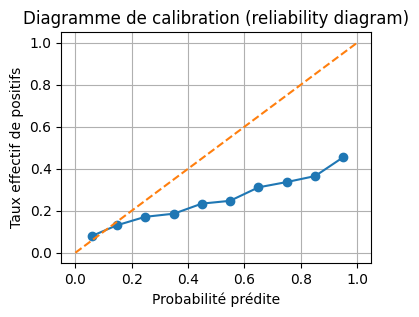

c:\Users\Amélie\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Brier score: 0.1553


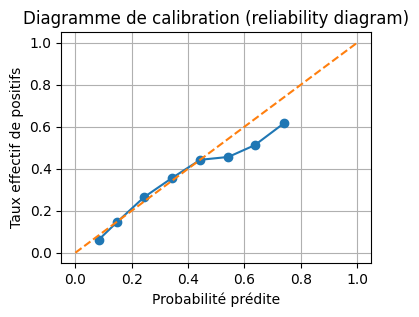

In [34]:
# Calibration : Comment l'interpréter ?
def Calibration(y_test, y_proba):
    # 5. Calcul de la courbe de calibration
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

    # 6. Calcul du Brier score
    brier = brier_score_loss(y_test, y_proba)
    print(f"Brier score: {brier:.4f}")

    # 7. Affichage du diagramme de fiabilité
    plt.figure(figsize=(4, 3))
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('Probabilité prédite')
    plt.ylabel('Taux effectif de positifs')
    plt.title('Diagramme de calibration (reliability diagram)')
    plt.grid(True)
    plt.show()

Calibration(y_test, y_proba)


#  Platt scaling (régression logistique sur scores)
calibrator = CalibratedClassifierCV(best_model, method='sigmoid', cv='prefit')
calibrator.fit(X_test, y_test)  # c'est bon de mettre ça?
y_prob_cal = calibrator.predict_proba(X_test)[:, 1]
Calibration(y_test, y_prob_cal) #et j'en fait quoi? Le Brier Score c'est le seuil que je dois mettre?

#### Sur modèle enrichi, il faudrait modifier les features de X_test

Index(['Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'NoWind_WindSpeed9am', 'WindDir9am_sin', 'WindDir9am_cos',
       'NoWind_WindSpeed3pm', 'WindDir3pm_sin', 'WindDir3pm_cos',
       'WindGustDir_sin', 'WindGustDir_cos', 'month_sin', 'month_cos',
       'Amplitude_Temp', 'Year_delta', 'Latitude_delta', 'Longitude_delta',
       'Mean_Temp', 'humidity_trend', 'cloud_mean', 'clearness_index',
       'wind_gustiness', 'u_gust', 'v_gust', 'u_9am', 'v_9am', 'month_angle'],
      dtype='object')

LogReg | F1: 0.416 | Acc: 0.723 | Seuil: 0.62
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.79      0.82     14591
           1       0.38      0.46      0.42      3974

    accuracy                           0.72     18565
   macro avg       0.61      0.63      0.62     18565
weighted avg       0.74      0.72      0.73    

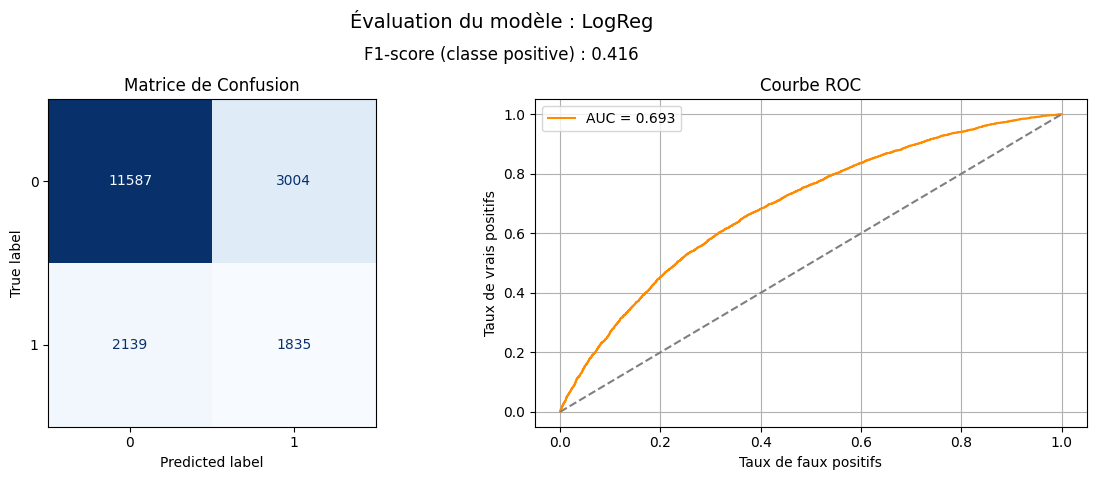

In [35]:
# Charger le classifier et son meilleur seuil
model_name = "LogReg"
nom_type_dataset = "X_train_enrichi"

# Enrichissement des features
X_test_enrichi = enrichissement_features(X_test)
print(X_test_enrichi.columns)


data = load("models/{0}_{1}_model_and_threshold.joblib".format(model_name, nom_type_dataset))
best_model     = data["model"]
best_threshold = data["threshold"]

# et pour prédire sur X_new :
y_proba = best_model.predict_proba(X_test_enrichi)[:,1]
y_pred  = (y_proba >= best_threshold).astype(int)

evaluation (y_test, y_pred, y_proba, model_name)

### XGB Classifier : Rappel score F1:0.84  | F1+: 0.652 | AUC: 0.879 | Seuil: 0.62


XGBClassifier | F1: 0.403 | Acc: 0.718 | Seuil: 0.31
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.79      0.82     14591
           1       0.37      0.44      0.40      3974

    accuracy                           0.72     18565
   macro avg       0.60      0.62      0.61     18565
weighted avg       0.74      0.72      0.73     18565

Rapport déséquilibre:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.79      0.44      0.82      0.59      0.36     14591
          1       0.37      0.44      0.79      0.40      0.59      0.34      3974

avg / total       0.74      0.72      0.52      0.73      0.59      0.36     18565



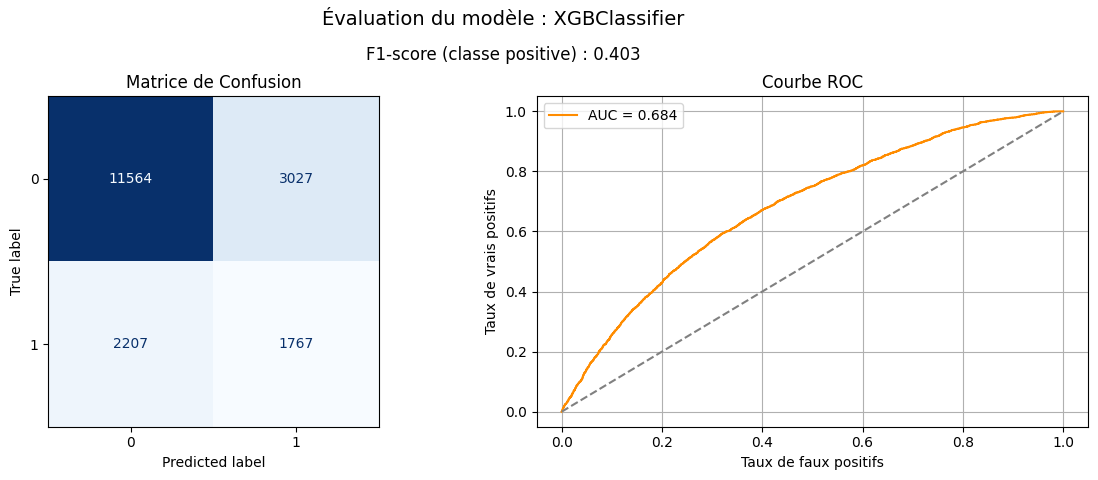

In [36]:
# Charger le classifier et son meilleur seuil
model_name = "XGBClassifier"
nom_type_dataset = "X_train"

data = load("models/{0}_{1}_model_and_threshold.joblib".format(model_name, nom_type_dataset))
best_model     = data["model"]
best_threshold = data["threshold"] # celui du modèle entrainé optimisé

# et pour prédire sur X_new :
y_proba = best_model.predict_proba(X_test)[:,1]
# En reprenant le seuil optimisé
y_pred  = (y_proba >= best_threshold).astype(int)

evaluation (y_test,y_pred, y_proba, model_name)

### RNN : Rappel score F1:0.682  | F1+: 0.86 | AUC: 0.900 | Seuil: 0.62

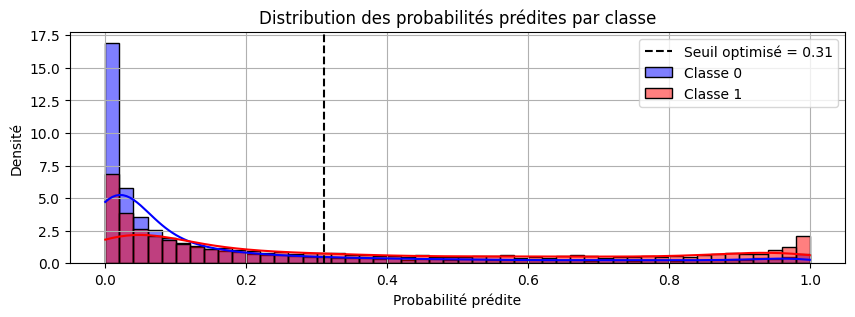

In [37]:
# Visualisation de la distribution des probabilités prédites par classe
plt.figure(figsize=(10, 3))

# Distribution des probabilités pour la classe 0
sns.histplot(y_proba[y_test == 0], bins=50, color='blue', label='Classe 0', stat='density', kde=True)

# Distribution des probabilités pour la classe 1
sns.histplot(y_proba[y_test == 1], bins=50, color='red', label='Classe 1', stat='density', kde=True)

# Ligne verticale pour le seuil optimisé
plt.axvline(x=best_threshold, color='black', linestyle='--', label=f'Seuil optimisé = {best_threshold:.2f}')

# Légendes et titre
plt.title('Distribution des probabilités prédites par classe')
plt.xlabel('Probabilité prédite')
plt.ylabel('Densité')
plt.legend()
plt.grid(True)
plt.show()


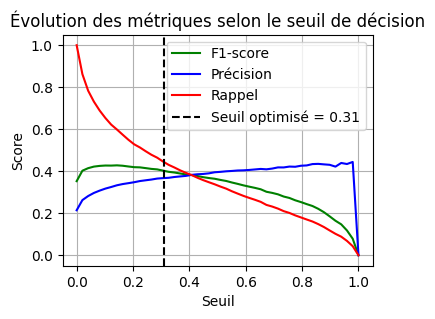

In [38]:
seuils = np.linspace(0, 1, 50)
f1_scores, precisions, recalls = [], [], []

for s in seuils:
    y_pred = (y_proba >= s).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    f1_scores.append(f1)
    precisions.append(p)
    recalls.append(r)

plt.figure(figsize=(4, 3))
plt.plot(seuils, f1_scores, label='F1-score', color='green')
plt.plot(seuils, precisions, label='Précision', color='blue')
plt.plot(seuils, recalls, label='Rappel', color='red')
plt.axvline(x=best_threshold, color='black', linestyle='--', label=f'Seuil optimisé = {best_threshold:.2f}')
plt.xlabel("Seuil")
plt.ylabel("Score")
plt.title("Évolution des métriques selon le seuil de décision")
plt.legend()
plt.grid(True)
plt.show()


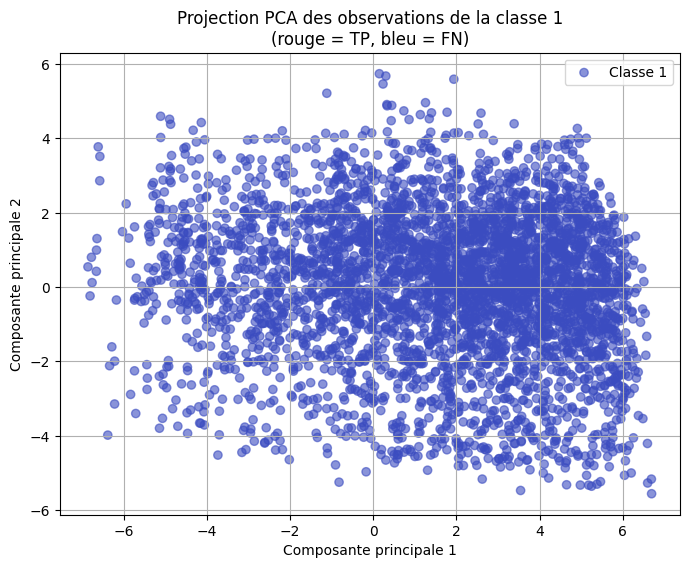

In [39]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_test)

plt.figure(figsize=(8,6))
plt.scatter(X_reduced[y_test==1][:,0], X_reduced[y_test==1][:,1], 
            c=(y_pred[y_test==1]==1), cmap='coolwarm', label='Classe 1', alpha=0.6)
plt.title("Projection PCA des observations de la classe 1\n(rouge = TP, bleu = FN)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.legend()
plt.show()


## Analyse des écarts de prédictions du XGBClassifier

#### Fonctions

In [40]:
def analyze_predictions(
    X_test: pd.DataFrame,
    y_true: pd.Series,
    y_pred: np.ndarray,
    y_proba: np.ndarray,
    scaler_path: str = "dico_scaler/scalers.joblib",
    dico_geo_path: str = "dico_scaler/dico_station_geo.pkl",
    dico_meta_path: str = "dico_scaler/dico_station.pkl",
) -> pd.DataFrame:
    """
    1. Chargement des scalers et des listes de features.
    2. Inverse le scaling des features de X_test.  
    3. Inverse le log-transform sur la colonne Rainfall.
    4. Recrée les coordonnées géographiques à partir des deltas.
    5. Charge les dictionnaires de géolocalisation et de métadonnées.
    6. Injecte les coordonnées géographiques dans le DataFrame.
    7. Ajoute les colonnes y_true, y_pred et l'erreur de prédiction.

    Retour:
        df_analyse (pd.DataFrame) : tableau enrichi pour analyse
    """
    # 1) Recharger scalers et listes
    art = load(scaler_path)
    scalers, feats = art['scalers'], art['feature_lists']
    df = X_test.copy()

    # 2) Inverse scaling sur chaque groupe
    for key, cols in feats.items():
        df[cols] = scalers[key].inverse_transform(df[cols])

    # 3) Inverse log-transform sur Rainfall
    if 'Rainfall' in df.columns:
        df['Rainfall'] = np.expm1(df['Rainfall'])  

    # 4) Recréer les coordonnées géographiques
    ref_year, lat0, lon0 = 2007, -25.0, 133.0
    df['Year']      = df['Year_delta']      + ref_year
    df['Latitude']  = df['Latitude_delta']  + lat0
    df['Longitude'] = df['Longitude_delta'] + lon0
    df['Latitude']  = df['Latitude'].round(7)
    df['Longitude'] = df['Longitude'].round(7)  
    
    # 5) charger dicts et construire df_geo, df_meta
    with open(dico_geo_path, "rb") as f:
        geo = pickle.load(f)
    df_geo = (
        pd.DataFrame.from_dict(geo, orient="index", columns=["Latitude","Longitude"])
          .reset_index().rename(columns={"index":"Location"})
    )
    
    with open(dico_meta_path, "rb") as f:
        meta = pickle.load(f)
    df_meta = (
        pd.DataFrame.from_dict(
            meta, orient="index",
            columns=["Nom_BOM","code_BOM","Location","note","District_Rainfall","Territory"]
        )
        .reset_index(drop=True)
    )

    # 6) injecter Location via merge sur coords, puis méta
    df = df.merge(df_geo, on=["Latitude","Longitude"], how="left") 
    df = df.merge(df_meta, on="Location", how="left")
    
    # 7) Ajouter y_true, y_pred
    df["y_true"] = y_true.values
    df["y_pred"] = y_pred
    df["y_proba"] = y_proba
    
    return df

In [41]:
def plot_confusion_matrices_by_station(df_result, n_cols=5):
    """
    Affiche une grille de matrices de confusion par station,
    triées par territoire, avec F1-score classe positive.

    Args:
        df_result (pd.DataFrame): DataFrame avec colonnes Location, Territory, y_true, y_pred.
        n_cols (int): Nombre de colonnes dans la grille (par défaut: 5).
    """
    # Trier les stations par Territory puis Location
    df_sorted = df_result.sort_values(by=["Territory", "Location"])
    stations = df_sorted["Location"].dropna().unique()

    n_stations = len(stations)
    n_rows = int(np.ceil(n_stations / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 4.5))
    axes = axes.flatten()

    for i, station in enumerate(stations):
        df_station = df_sorted[df_sorted["Location"] == station]

        if df_station["y_true"].isna().all():
            continue

        territory = df_station["Territory"].unique()[0]
        y_true = df_station["y_true"]
        y_pred = df_station["y_pred"]

        cm = confusion_matrix(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, pos_label=1)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[i], cmap="Blues", values_format="d", colorbar=False)

        axes[i].set_title(f"{station}\n({territory})\nF1 (classe 1): {f1:.2f}", fontsize=9)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

    # Supprimer les subplots vides
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [42]:
def plot_confusion_matrices_by_a_feature(df_result, n_cols=4, feature="Territory"):
    """
    Affiche une matrice de confusion par valeur d'une feature, avec F1-score classe positive.
    """
    list_values_in_feature = sorted(df_result[feature].dropna().unique())
    n_values = len(list_values_in_feature)
    n_rows = int(np.ceil(n_values / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    axes = axes.flatten()

    for i, value in enumerate(list_values_in_feature):
        df_on_a_value = df_result[df_result[feature] == value]

        if df_on_a_value["y_true"].isna().all():
            continue

        y_true = df_on_a_value["y_true"]
        y_pred = df_on_a_value["y_pred"]

        cm = confusion_matrix(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, pos_label=1)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[i], cmap="Blues", values_format="d", colorbar=False)

        axes[i].set_title(f"{value}\nF1 (classe 1): {f1:.2f}", fontsize=10)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

    # Supprimer les subplots non utilisés
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


#### Préparation d'un df (df_analysis_result) consolidant X_test, y_pred, y_proba et y_test et remettant les features initiales pour faciliter l'analyse

In [43]:
df_analysis_result = analyze_predictions(
    X_test=X_test,
    y_true=y_test,
    y_pred=y_pred,
    y_proba=y_proba,    
    scaler_path="dico_scaler/scalers.joblib",
    dico_geo_path="dico_scaler/dico_station_geo.pkl",
    dico_meta_path="dico_scaler/dico_station.pkl")

display(df_analysis_result.head(10))
df_analysis_result.columns

,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,...,Longitude,Location,Nom_BOM,code_BOM,note,District_Rainfall,Territory,y_true,y_pred,y_proba
0,0.0,35.0,15.0,24.0,74.0,42.0,1033.5,1029.2,7.0,6.0,...,138.599931,Adelaide,Adelaide Airport,023034,Note 1,23,South Australia,0,0,0.00453


Index(['Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
       'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am',
       'Cloud3pm', 'Temp9am', 'Temp3pm', 'NoWind_WindSpeed9am',
       'WindDir9am_sin', 'WindDir9am_cos', 'NoWind_WindSpeed3pm',
       'WindDir3pm_sin', 'WindDir3pm_cos', 'WindGustDir_sin',
       'WindGustDir_cos', 'month_sin', 'month_cos', 'Amplitude_Temp',
       'Year_delta', 'Latitude_delta', 'Longitude_delta', 'Year', 'Latitude',
       'Longitude', 'Location', 'Nom_BOM', 'code_BOM', 'note',
       'District_Rainfall', 'Territory', 'y_true', 'y_pred', 'y_proba'],
      dtype='object')

3974 faux négatifs détectés


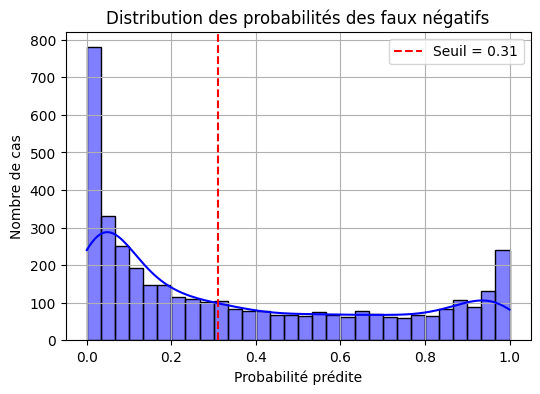

In [44]:
# Visualiser la distribution des probabilités des faux négatifs
faux_negatifs = df_analysis_result[
    (df_analysis_result['y_true'] == 1) & (df_analysis_result['y_pred'] == 0)
]
print(f"{len(faux_negatifs)} faux négatifs détectés")

plt.figure(figsize=(6,4))
sns.histplot(faux_negatifs['y_proba'], bins=30, kde=True, color='blue')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Seuil = {best_threshold:.2f}')
plt.title("Distribution des probabilités des faux négatifs")
plt.xlabel("Probabilité prédite")
plt.ylabel("Nombre de cas")
plt.legend()
plt.grid(True)
plt.show()


In [46]:
# Étape 1 : sélectionner uniquement les features (hors colonnes cibles)
features = [col for col in df_analysis_result.columns if col not in ['y_true', 'y_pred', 'y_proba']]

# Étape 2 : filtrer uniquement les colonnes numériques parmi ces features
features_num = df_analysis_result[features].select_dtypes(include=['number']).columns.tolist()

# Étape 3 : sélectionner les faux négatifs et vrais positifs
faux_negatifs = df_analysis_result[(df_analysis_result['y_true'] == 1) & (df_analysis_result['y_pred'] == 0)]
vrais_positifs = df_analysis_result[(df_analysis_result['y_true'] == 1) & (df_analysis_result['y_pred'] == 1)]

# Étape 4 : calcul des moyennes sur les features numériques
comparaison = pd.DataFrame({
    'Faux_Négatif (moy)': faux_negatifs[features_num].mean(),
    'Vrai_Positif (moy)': vrais_positifs[features_num].mean(),
})

# Étape 5 : calcul de l'écart relatif en pourcentage
comparaison['Ecart_rel (%)'] = 100 * (
    comparaison['Vrai_Positif (moy)'] - comparaison['Faux_Négatif (moy)']
) / (comparaison['Vrai_Positif (moy)'].abs() + 1e-6)

# Étape 6 : tri décroissant
comparaison = comparaison.sort_values(by='Ecart_rel (%)', ascending=False)

# Étape 7 : affichage des plus gros écarts
display(comparaison.head(10))


,Faux_Négatif (moy),Vrai_Positif (moy),Ecart_rel (%)
Rainfall,6.213252,NaN,NaN
WindGustSpeed,40.463532,NaN,NaN
WindSpeed9am,14.728286,NaN,NaN
WindSpeed3pm,19.103901,NaN,NaN
Humidity9am,78.831808,NaN,NaN
Humidity3pm,63.676771,NaN,NaN
Pressure9am,1018.227542,NaN,NaN
Pressure3pm,1016.209724,NaN,NaN
Cloud9am,5.601661,NaN,NaN
Cloud3pm,5.489683,NaN,NaN


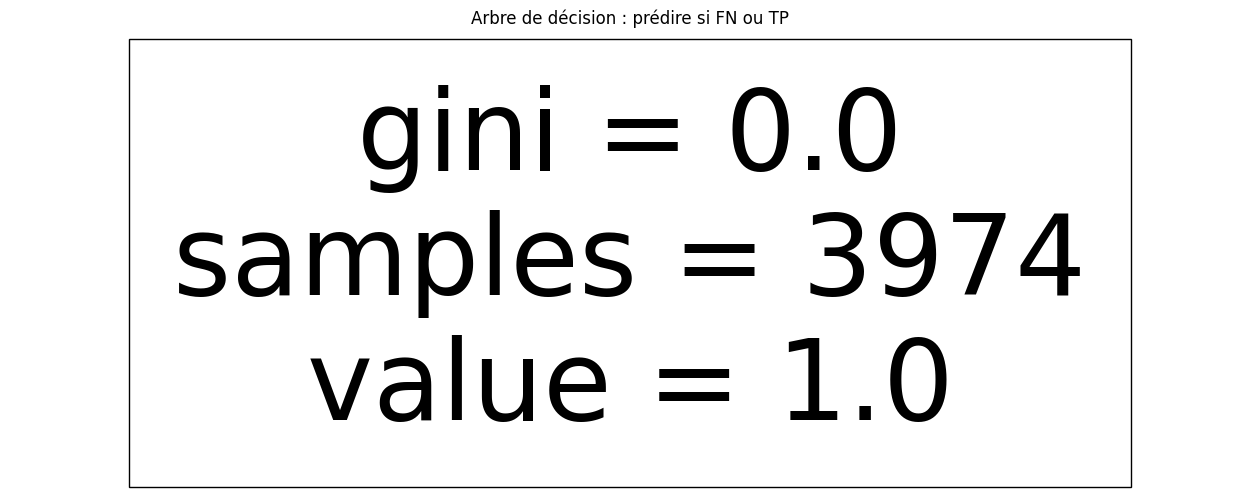

In [47]:
df_fntp = pd.concat([faux_negatifs, vrais_positifs])
cols_to_drop = ['Nom_BOM', 'code_BOM', 'note', 'District_Rainfall',"Location"]
df_fntp = df_fntp.drop(columns=cols_to_drop, errors='ignore')

df_fntp_encoded = pd.get_dummies(df_fntp, columns=['Territory'], drop_first=True)

features_encoded = [col for col in df_fntp_encoded.columns if col not in ['y_true', 'y_pred', 'y_proba']]
X_fntp = df_fntp_encoded[features_encoded]
y_fntp = (df_fntp_encoded['y_pred'] == 1).astype(int)


tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_fntp, y_fntp)

plt.figure(figsize=(16, 6))
plot_tree(tree, feature_names=features, class_names=['FN', 'TP'], filled=True)
plt.title("Arbre de décision : prédire si FN ou TP")
plt.show()


comment goulburn s'est fait scalé : trouver un index d'X_test où Goulburn a un NAN et voir ce index avant scaling: voir avant /scalé / apres de lignes avec NaN et comparé avec autre station pour voir la cohérence

Meilleure généralisation sur des données jamais vues (Stations jamais vues : Goulburn, (supprimées en préprocessing : Melbourne, ...)

In [48]:
df_analysis_result.loc[df_analysis_result["Location"]=="PB_Goulburn"].head(1)

,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,...,Longitude,Location,Nom_BOM,code_BOM,note,District_Rainfall,Territory,y_true,y_pred,y_proba
18170,0.2,31.0,6.0,20.0,83.0,59.0,1031.6,1030.1,1.0,6.0,...,149.725,PB_Goulburn,Goulburn: Goulburn Airport AWS combined Goulbu...,070330,,70,Australian Capital Territory,0,0,0.135943


##### Réencodage

In [49]:
df_analysis_result['Month_decoded'] = np.round(
    (np.arctan2(df_analysis_result['month_sin'], df_analysis_result['month_cos']) / (2 * np.pi) * 12) + 1
).astype(int)

# Corriger les valeurs possibles de 13 ou 0 à cause de l'arrondi
df_analysis_result['Month_decoded'] = df_analysis_result['Month_decoded'].mod(12)
df_analysis_result['Month_decoded'] = df_analysis_result['Month_decoded'].replace(0, 12)

In [50]:
# Étape 1 : Fonction de décodage de la direction du vent
def decode_wind_direction(sin_col, cos_col, directions=(
    "N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE",
    "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"
)):
    angles = np.array([i * 2 * np.pi / 16 for i in range(16)])
    def closest_direction(sin_val, cos_val):
        if np.isnan(sin_val) or np.isnan(cos_val):
            return np.nan
        angle = np.arctan2(sin_val, cos_val) % (2 * np.pi)
        idx = np.argmin(np.abs(angles - angle))
        return directions[idx]
    return [closest_direction(s, c) for s, c in zip(sin_col, cos_col)]

# Étape 2 : Application sur le DataFrame contenant les colonnes encodées
for base in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    sin_col = df_analysis_result[f"{base}_sin"]
    cos_col = df_analysis_result[f"{base}_cos"]
    df_analysis_result[base] = decode_wind_direction(sin_col, cos_col)

# Étape 3 : Suppression des colonnes encodées
df_analysis_result.drop(columns=[
    'WindGustDir_sin', 'WindGustDir_cos',
    'WindDir9am_sin', 'WindDir9am_cos',
    'WindDir3pm_sin', 'WindDir3pm_cos',
    'NoWind_WindSpeed9am', 'NoWind_WindSpeed3pm'
], inplace=True, errors='ignore')  # errors='ignore' pour éviter crash si colonne manquante


In [51]:
df_analysis_result = df_analysis_result.drop(['month_sin', 'month_cos', 'Year_delta', 'Latitude_delta', 'Longitude_delta'], axis=1)  

#### Identifier les problèmes de généralisation : un territoire est particulièrement mal prédit? une station? un mois?

In [52]:
df_analysis_result.loc[df_analysis_result["Location"]=="PB_Goulburn"].head(1)

,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,...,note,District_Rainfall,Territory,y_true,y_pred,y_proba,Month_decoded,WindGustDir,WindDir9am,WindDir3pm
18170,0.2,31.0,6.0,20.0,83.0,59.0,1031.6,1030.1,1.0,6.0,...,,70,Australian Capital Territory,0,0,0.135943,5,SE,SSE,ESE


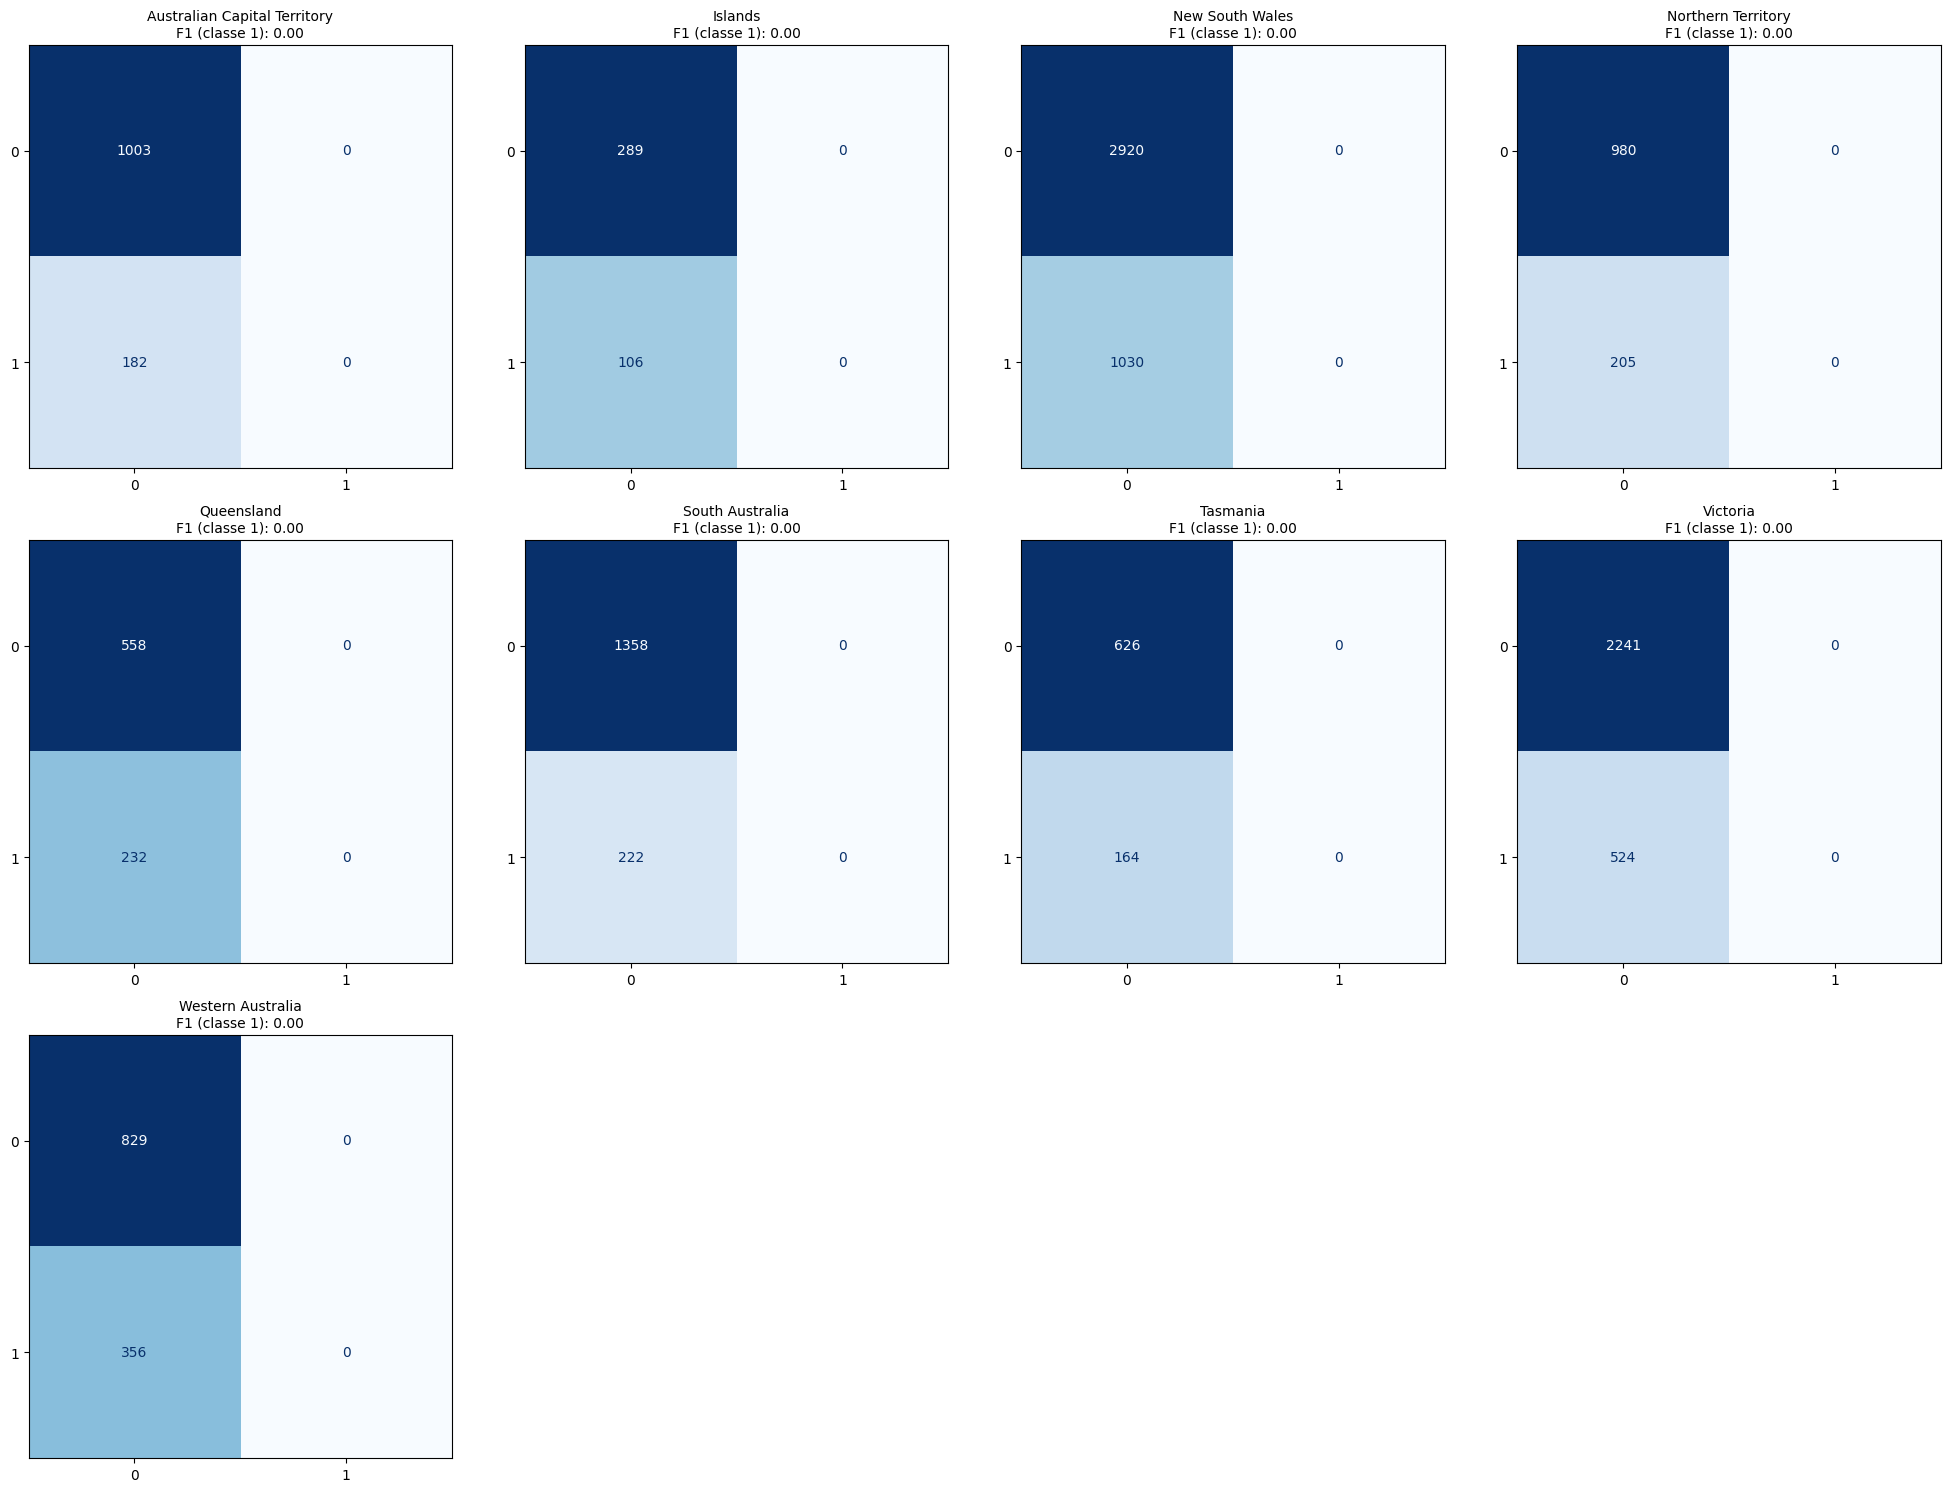

In [53]:
plot_confusion_matrices_by_a_feature(df_analysis_result, feature="Territory")

In [ ]:
plot_confusion_matrices_by_station(df_analysis_result)

In [ ]:
plot_confusion_matrices_by_a_feature(df_analysis_result, feature="Month_decoded")